# Locus To Gene

This notebook aims to restructure and test L2G

In [1]:
import sys

import loguru
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

from gentropy.common.session import Session
from gentropy.dataset.dataset import Dataset

logger = loguru.logger


Loading BokehJS ...

In [2]:
RELEASE_PATH="/Users/ss60/2503-testrun-1/output"
session = Session(extended_spark_conf={"spark.driver.memory": "14g", "spark.driver.maxResultSize": 0})

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/26 07:13:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
%matplotlib

## Methods

below you can find methods I used to analyse the datasets

In [11]:
def plot_distributions(df: pl.DataFrame, feature_cols: list[str]) -> None:
    """Plot the distribution of the features in the dataframe."""
    # Set the optimal number of dist plots
    combinations = [5,4,3,2,1]
    reminders = [len(feature_cols) % v for v in combinations]
    # for each combination count the reminder and save
    minimal_reminder = min(reminders)
    combination_idx = reminders.index(minimal_reminder)
    plots_per_row = combinations[combination_idx]

    logger.debug("Lowest reminder %s for %s ", minimal_reminder, plots_per_row)
    if len(feature_cols) % plots_per_row == 0:
        plots_per_col = len(feature_cols) // plots_per_row
    else:
        plots_per_col = len(feature_cols) // plots_per_row

    logger.debug(f"Shape [{plots_per_row}, {plots_per_col}]", plots_per_row, plots_per_col)
    with plt.style.context("fast"):
        fig, ax = plt.subplots(nrows=plots_per_col, ncols=plots_per_row)
        fig.tight_layout()
        fig.set_figheight(plots_per_col*2)
        fig.set_figwidth(plots_per_row*2)
        for i in range(0, plots_per_col):
            for j in range(0, plots_per_row):
                current_col_idx = i * plots_per_row + j
                if len(feature_cols) == current_col_idx:
                    break
                logger.debug(f"Plotting to row {i}, col {j} data from {feature_cols[current_col_idx]}")
                if ax.ndim == 1:
                    dims = (i)
                else:
                    dims = (i,j)
                ax[*dims].hist(x=df[feature_cols[current_col_idx]], bins=100)
                ax[*dims].set_title(feature_cols[current_col_idx], fontsize="small")


    return fig



In [75]:
def plot_wiskers(df: pl.DataFrame, feature_cols: list[str]):
    """Build the boxplots for the feature columns."""
    with plt.style.context("fast"):
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
        all_data = df.select(feature_cols)
        axs.boxplot(all_data, orientation="horizontal", showmeans=True, tick_labels=all_data.columns)
        axs.yaxis.grid(True)
        return fig



In [8]:
def calculate_skewness(df: pl.DataFrame, feature_cols: list[str]):
    """Calculate skewness for all columns."""
    return (
        df.select(*[pl.col(feature).skew() for feature in feature_cols])
        .transpose(include_header=True, header_name="feature_name", column_names=["value"])
        .sort(pl.col("value"))
    )

## Feature matrix
Current implementation of the L2G feature matrix and how it is build

In [5]:
fm = session.load_data(path=f"{RELEASE_PATH}/l2g_feature_matrix")

### Feature matrix content

Below you can find what is exactly in the feature matrix

In [6]:
fm.show()
fm.printSchema()

25/02/26 07:14:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------------+---------------------+---------------------+----------------------------------+-------------------------+--------------------------------------+-------------------+--------------------------------+---------------+----------------------------+--------------------+---------------------------------+------------------+-------------------------------+--------------+---------------+--------------------+---------------------------------+------------------+-------------------------------+---------------------+--------------------+---------------------------------+------------------+-------------------------------+----------+-----------------------+------------+--------------------+
|        studyLocusId|         geneId|credibleSetConfidence|distanceFootprintMean|distanceFootprintMeanNeighbourhood|distanceSentinelFootprint|distanceSentinelFootprintNeighbourhood|distanceSentinelTss|distanceSentinelTssNeighbourhood|distanceTssMean|distanceTssMeanNeighbourhood

inside the feature matrix we have the static columns:
- studyLocusId
- geneId

and multiple feature columns, some of them are `double` type:
- geneCount500kb
- proteinGeneCount500kb
Other columns are `float` type.


## Check if the feature matrix feature fields distribution(s)

I want to see the distribution of the features in the feature matrix

In [9]:
static_columns = ["geneId", "studyLocusId"]
features = [f for f in fm.columns if f not in static_columns]
logger.info(f"We have {len(features)} features")


2025-02-26 07:18:42.227 | INFO     | __main__:<module>:3 - We have 28 features


2025-02-26 07:19:11.142 | DEBUG    | __main__:plot_distributions:11 - Lowest reminder %s for %s 
2025-02-26 07:19:11.142 | DEBUG    | __main__:plot_distributions:17 - Shape [4, 7]
2025-02-26 07:19:11.345 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 0 data from credibleSetConfidence
2025-02-26 07:19:11.591 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 1 data from distanceFootprintMean
2025-02-26 07:19:11.776 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 2 data from distanceFootprintMeanNeighbourhood
2025-02-26 07:19:12.025 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 3 data from distanceSentinelFootprint
2025-02-26 07:19:12.374 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 1, col 0 data from distanceSentinelFootprintNeighbourhood
2025-02-26 07:19:12.630 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 1, col 1 data from distanceSentinelTss
2025-02-26 07:19:12.822 | 

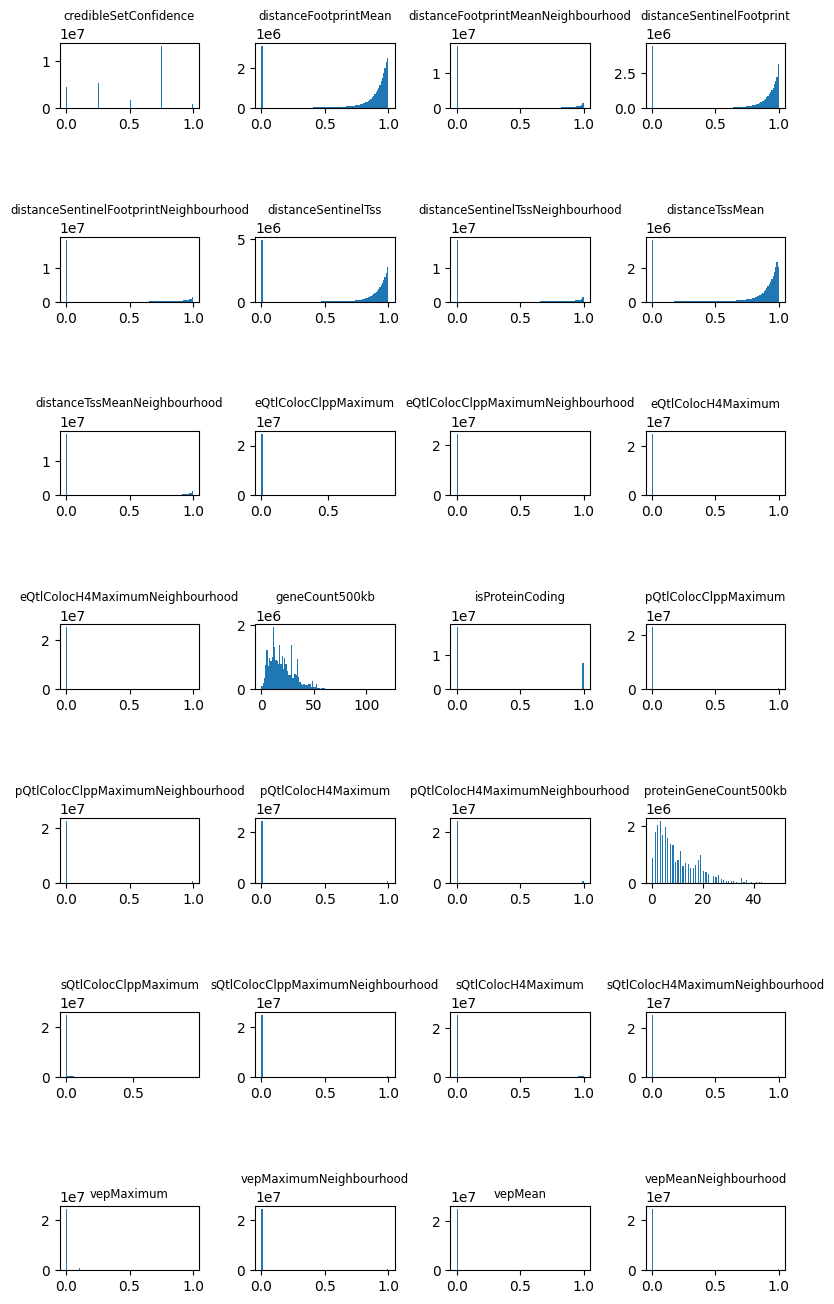

In [12]:
fm_pl = pl.read_parquet(f"{RELEASE_PATH}/l2g_feature_matrix/*.parquet")
fig = plot_distributions(fm_pl, feature_cols=features)
plt.show()

Since the features are skewed torwards right side, lets calculate the skewness

In [13]:
with pl.Config(tbl_rows=len(features)):
    skew_df = calculate_skewness(fm_pl, feature_cols=features)
    print(skew_df)

shape: (28, 2)
┌─────────────────────────────────┬───────────┐
│ feature_name                    ┆ value     │
│ ---                             ┆ ---       │
│ str                             ┆ f64       │
╞═════════════════════════════════╪═══════════╡
│ distanceFootprintMean           ┆ -1.903504 │
│ distanceTssMean                 ┆ -1.717013 │
│ distanceSentinelFootprint       ┆ -1.571269 │
│ distanceSentinelTss             ┆ -1.43913  │
│ credibleSetConfidence           ┆ -0.500911 │
│ isProteinCoding                 ┆ 0.910598  │
│ distanceFootprintMeanNeighbour… ┆ 0.958182  │
│ distanceSentinelFootprintNeigh… ┆ 1.021568  │
│ distanceTssMeanNeighbourhood    ┆ 1.022901  │
│ distanceSentinelTssNeighbourho… ┆ 1.081101  │
│ geneCount500kb                  ┆ 1.087984  │
│ proteinGeneCount500kb           ┆ 1.250589  │
│ pQtlColocClppMaximumNeighbourh… ┆ 3.258244  │
│ pQtlColocClppMaximum            ┆ 4.651273  │
│ pQtlColocH4MaximumNeighbourhoo… ┆ 4.748006  │
│ pQtlColocH4Maximum     

The skewness is quiet diverse, this is due to the fact that we fill missing values with 0. **From what I understand how the features are build** the fill_na should only happen on coloc features. Further investigation is needed for all other features including 
- distance
- vep
for which I was not expecting so much skewness.




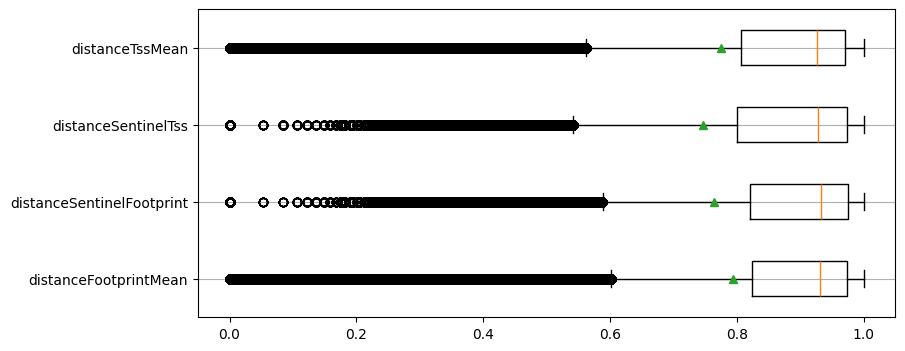

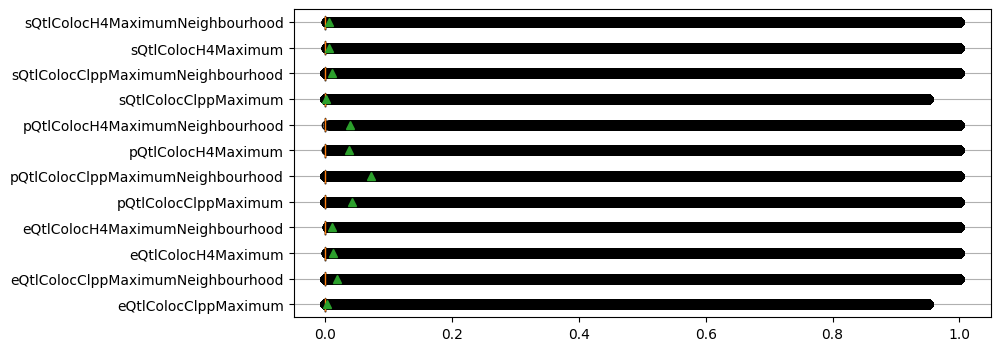

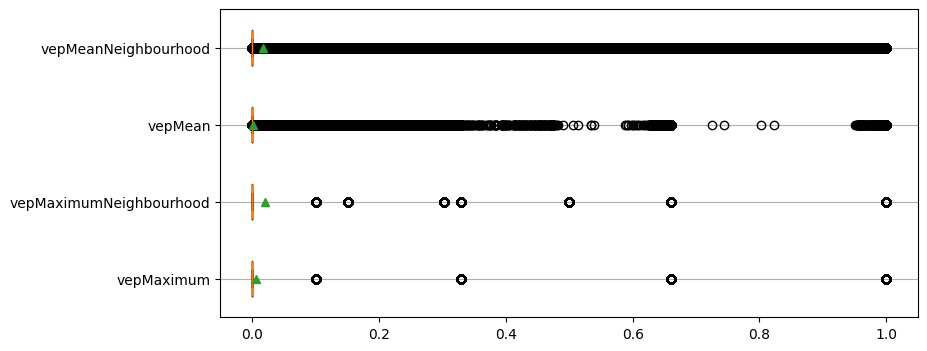

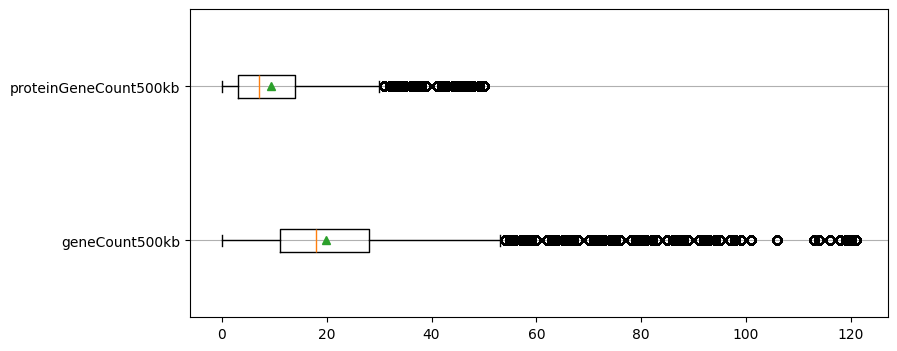

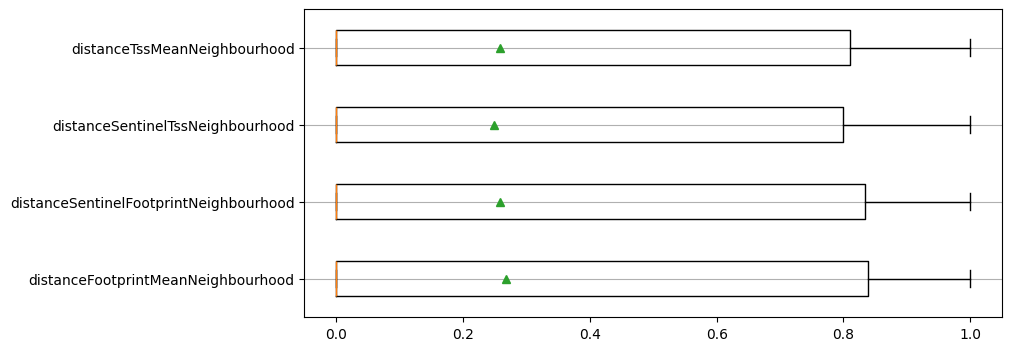

In [76]:
distance_neighbourhood_features = [f for f in features if "distance" in f and f.endswith("hood")]
distance_features = [f for f in features if "distance" in f and not f.endswith("hood")]
coloc_features = [f for f in features if "Coloc" in f]
vep_features = [f for f in features if "vep" in f]
gene_cnt_features = [f for f in features if "500kb" in f]

fig = plot_wiskers(fm_pl, distance_features)
fig2 = plot_wiskers(fm_pl, coloc_features)
fig3 = plot_wiskers(fm_pl, vep_features)
fig4 = plot_wiskers(fm_pl, gene_cnt_features)
fig5 = plot_wiskers(fm_pl, distance_neighbourhood_features)
plt.show()

Given we how have a full overview of the skewed data, I would like to try using the `power_transform`. lets have a look at the example with the colocalisation featues.

### Disclaimer

Since we use an ensembl algorithm that is based on tree, the transformation of the features may have minimal to none impact

In [80]:
# See the distribution after applying power transformation
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [82]:
PowerTransformer(method="yeo-johnson").fit_transform(fm_pl.select(coloc_features))

array([[-0.18546785, -0.17290184, -0.12146713, ..., -0.12904851,
        -0.08280539, -0.08033198],
       [-0.18546785, -0.17290184, -0.12146713, ..., -0.12904851,
        -0.08280539, -0.08033198],
       [-0.18546785, -0.17290184, -0.12146713, ..., -0.12904851,
        -0.08280539, -0.08033198],
       ...,
       [-0.18546785, -0.17290184, -0.12146713, ..., -0.12904851,
        -0.08280539, -0.08033198],
       [-0.18546785, -0.17290184, -0.12146713, ..., -0.12904851,
        -0.08280539, -0.08033198],
       [-0.18546785, -0.17290184, -0.12146713, ..., -0.12904851,
        -0.08280539, -0.08033198]])

shape: (25_352_414,)
Series: 'studyLocusId' [str]
[
	"000d98bdeb82ea3a9606b827b8dc80…
	"000d98bdeb82ea3a9606b827b8dc80…
	"000d98bdeb82ea3a9606b827b8dc80…
	"000d98bdeb82ea3a9606b827b8dc80…
	"000d98bdeb82ea3a9606b827b8dc80…
	…
	"ffe880538ab1a59ca79fc94a967cce…
	"ffe880538ab1a59ca79fc94a967cce…
	"ffe880538ab1a59ca79fc94a967cce…
	"ffe880538ab1a59ca79fc94a967cce…
	"ffe880538ab1a59ca79fc94a967cce…
]
shape: (25_352_414,)
Series: 'geneId' [str]
[
	"ENSG00000186591"
	"ENSG00000106459"
	"ENSG00000272701"
	"ENSG00000278055"
	"ENSG00000274500"
	…
	"ENSG00000287984"
	"ENSG00000296707"
	"ENSG00000298182"
	"ENSG00000255032"
	"ENSG00000019505"
]
shape: (25_352_414,)
Series: 'credibleSetConfidence' [f32]
[
	0.75
	0.75
	0.75
	0.75
	0.75
	…
	0.5
	0.5
	0.5
	0.5
	0.5
]
shape: (25_352_414,)
Series: 'distanceFootprintMean' [f32]
[
	0.985601
	0.939167
	0.800058
	0.795332
	0.791884
	…
	0.984022
	0.990316
	0.990418
	0.966702
	0.919292
]
shape: (25_352_414,)
Series: 'distanceFootprintMeanNeighbourhood' [f32]
[
	